In [ ]:
import numpy as np
import torch
import torch.optim as optim
from torch.distributions.bernoulli import Bernoulli
from utils import *

from causalml.inference.meta import BaseDRRegressor
from sklearn.linear_model import LinearRegression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set_theme()

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def manipulation_soft(u, v, n, card_u, model, c=0.1):
    v_target = v.repeat_interleave(torch.tensor([card_u]).repeat_interleave(n), dim=0)
    u_target = torch.eye(card_u).repeat(n, 1)
    x_target = torch.cat((u_target, v_target), dim=1)
    pi = model(x_target).view(-1, card_u)
    u_init = u.repeat_interleave(torch.tensor([card_u]).repeat_interleave(n), dim=0)
    _, u_init_category = torch.where(u_init == 1)
    _, u_taregt_category = torch.where(u_target == 1)
    cost = torch.abs(u_taregt_category - u_init_category).view(-1, card_u)
    inputs = torch.cat((v, pi), dim=1)
    utility = pi - c * cost
    soft_utility = (torch.softmax(5 * utility, dim=1) ) # to strengthen the utility, otherwise it's near to random
    index = soft_utility.multinomial(num_samples = 1).reshape(-1)
    u_shift = torch.zeros((n, card_u))
    u_shift[torch.arange(n), index] = 1
    return inputs, index.view(-1, 1), u_shift


In [3]:
torch.set_default_dtype(torch.float32)
torch.set_default_device("cuda")
torch.manual_seed(1)

dim_v = 20
card_u = 5
beta = torch.tensor(list(np.linspace(-5, 5, card_u)) + list(np.random.normal(0, 1, size = (dim_v,))), dtype=torch.float32).view(-1, 1)
trans = torch.rand((dim_v, card_u), dtype=torch.float32)

H = 30
len_seq = 100
num_epoch = 300

T = 100
n = 3000
n_eval = 10000
repeat_num = 5

# fix samples for policy eval 
u_eval, v_eval = x_generate(n_eval, dim_v, trans, seed=0)

# generate sequential data (before manipulation)
seed_list = range(10)
dataset = {}
for s in seed_list:
    dataset[s] = [x_generate(n, dim_v, trans, seed=s) for i in range(T)]

In [ ]:
def manipulation_cutoff_soft(u, v, n, card_u, beta, c=0.1):
    v_target = v.repeat_interleave(torch.tensor([card_u]).repeat_interleave(n), dim=0)
    u_target = torch.eye(card_u).repeat(n, 1)
    x_target = torch.cat((u_target, v_target), dim=1)
    tau = x_target @ beta
    pi = torch.where(tau > 0, torch.tensor(1), torch.tensor(0)).view(-1, card_u)
    u_init = u.repeat_interleave(torch.tensor([card_u]).repeat_interleave(n), dim=0)
    _, u_init_category = torch.where(u_init == 1)
    _, u_taregt_category = torch.where(u_target == 1)
    cost = torch.abs(u_taregt_category - u_init_category).view(-1, card_u)
    utility = pi - c * cost
    soft_utility = (torch.softmax(5 * utility, dim=1) ) # to strengthen the utility, otherwise it's near to random
    index = soft_utility.multinomial(num_samples = 1).reshape(-1)
    u_shift = torch.zeros((n, card_u))
    u_shift[torch.arange(n), index] = 1
    return u_shift


def cutoff_soft(seed, card_u, beta, n_eval, cost_coef=0.1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    # global access u_eval, v_eval
    u_eval_shift = manipulation_cutoff_soft(u_eval, v_eval, n_eval, card_u, beta, c=cost_coef) 
    x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
    tau_eval = x_eval @ beta
    pi_eval = torch.where(tau_eval > 0, torch.tensor(1), torch.tensor(0))
    value = torch.mean(pi_eval * tau_eval)
    return value.item()

In [ ]:
mani_u_list_mm = []


def StrategicGD_soft(seed, dim_v, card_u, beta, H,  len_seq, num_epoch, T, n, n_eval, lr_pi = 0.01, lr_prob = 0.01, cost_coef = 0.05):
    print(seed)
    torch.set_default_dtype(torch.float32) 
    torch.set_default_device("cuda")

    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)

    num_hiddens_pi = 2 * (dim_v + card_u)
    model_pi = allocation_policy(dim_v + card_u, num_hiddens_pi)
    num_hiddens_prob = 2 * (dim_v + card_u)
    model_prob = shifted_distribution(card_u, num_hiddens_prob, card_u)
    cate_learner = BaseDRRegressor(learner=LinearRegression(), treatment_effect_learner=LinearRegression())
    
    patience = 3    
    
    t = 0
    seq_revenue = []
    seq_loss = []
    seq_val = []
    seq_inputs = []
    seq_category = []
    seq_x = []
    seq_z = []
    seq_y = []
    seq_pi = []
    
    optimizer_pi = optim.Adam(model_pi.parameters(), lr=lr_pi)    
    
    for t in range(H):
        u, v = dataset[seed][t]
        inputs, u_category, u_shift = manipulation_soft(u, v, n, card_u, model_pi, c=cost_coef)
        inputs = inputs[:,-card_u:]                
        mani_u_list_mm.append(u_shift)
        # training of allocation policy
        x = torch.cat((u_shift, v), dim=1)
        pi = model_pi(x)
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x, z, n, beta, seed=seed)
        seq_inputs.append(inputs.detach())
        seq_category.append(u_category)
        seq_x.append(x)
        seq_z.append(z)
        seq_y.append(y)
        seq_pi.append(pi)

        cate_fit(seq_x, seq_y, seq_z, seq_pi, cate_learner)
        tau = cate_predict(x, pi, cate_learner).cuda()    
        revenue = - torch.mean(pi * tau.detach())

        optimizer_pi.zero_grad()
        revenue.backward()
        optimizer_pi.step()

        # evaluation of allocation policy    
        _, _, u_eval_shift = manipulation_soft(u_eval, v_eval, n_eval, card_u, model_pi, c=cost_coef)
        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        pi_eval = model_pi(x_eval)
        tau_eval = x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)
        seq_revenue.append(value.item())

    # training of the shifted distribution
    stacked_inputs = torch.cat(seq_inputs, dim=0)
    stacked_category = torch.cat(seq_category, dim=0)

    random_indices = torch.randperm(stacked_inputs.shape[0])
    stacked_inputs = stacked_inputs[random_indices]
    stacked_category = stacked_category[random_indices]

    n_sample = int(stacked_inputs.shape[0] * 0.8)

    train_inputs = stacked_inputs[0:n_sample, :]
    train_category = stacked_category[0:n_sample, :]
    val_inputs = stacked_inputs[n_sample:, :]
    val_category = stacked_category[n_sample:, :]

    early_stop_counter = 0
    best_val_loss = float('inf')

    loss_function = nn.CrossEntropyLoss()
    optimizer_prob = optim.SGD(model_prob.parameters(), lr=lr_prob)
    for epoch in range(num_epoch):
        loss = loss_function(model_prob(train_inputs), train_category.view(-1))
        optimizer_prob.zero_grad()
        loss.backward()
        optimizer_prob.step()
        seq_loss.append(loss.item())
        loss_val = loss_function(model_prob(val_inputs), val_category.view(-1))
        seq_val.append(loss_val.item())
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            break
    
    optimizer_pi = optim.Adagrad(model_pi.parameters(), lr=lr_pi)
    
    while True:
        t = t + 1
        u, v = dataset[seed][t]
        inputs, u_category, u_shift = manipulation_soft(u, v, n, card_u, model_pi, c=cost_coef)  
        inputs = inputs[:,-card_u:]        
        
        # record u after manipulation
        mani_u_list_mm.append(u_shift)                
        seq_inputs.append(inputs.detach())
        seq_category.append(u_category)

        if len(seq_inputs) > len_seq:
            seq_inputs.pop(0)
            seq_category.pop(0)

        # train model pi
        x = torch.cat((u_shift, v), dim=1)        
        z = Bernoulli(probs=pi).sample()
        y = y_generate(x, z, n, beta, seed=seed)
        seq_x.append(x)
        seq_z.append(z)
        seq_y.append(y)
        pi = model_pi(x)  
        seq_pi.append(pi) 
        
        log_prob = nn.LogSoftmax(dim=1)(model_prob(inputs))[torch.arange(n), u_category.view(-1)]              
        tau = cate_predict(x, pi, cate_learner).cuda()                                             
        revenue = - torch.mean(pi * tau) -  torch.mean(pi.detach() * tau * log_prob)            
        optimizer_pi.zero_grad()
        revenue.backward(retain_graph=True)        
        optimizer_pi.step()

        # evaluation of allocation policy
        _, _, u_eval_shift = manipulation_soft(u_eval, v_eval, n_eval, card_u, model_pi, c=cost_coef)
        x_eval = torch.cat((u_eval_shift, v_eval), dim=1)
        pi_eval = model_pi(x_eval)
        tau_eval = x_eval @ beta
        value = torch.mean(pi_eval * tau_eval)
        seq_revenue.append(value.item())
        
        if t >= T - 1:
            break
            
    plt.figure(figsize=(16,6))
    plt.subplot(1, 2, 1)
    plt.plot(seq_revenue)

    plt.subplot(1, 2, 2)
    plt.plot(seq_loss, label='train loss')
    plt.plot(seq_val, label='val loss')
    plt.legend()
    plt.show()

    return seq_revenue


0


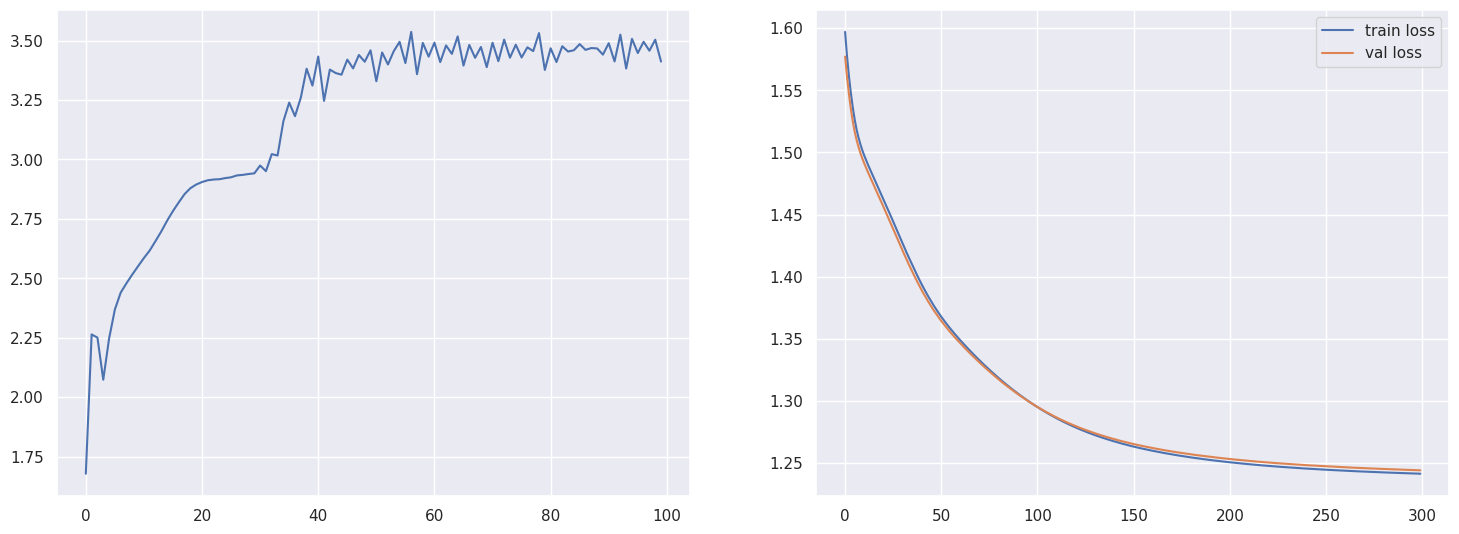

1


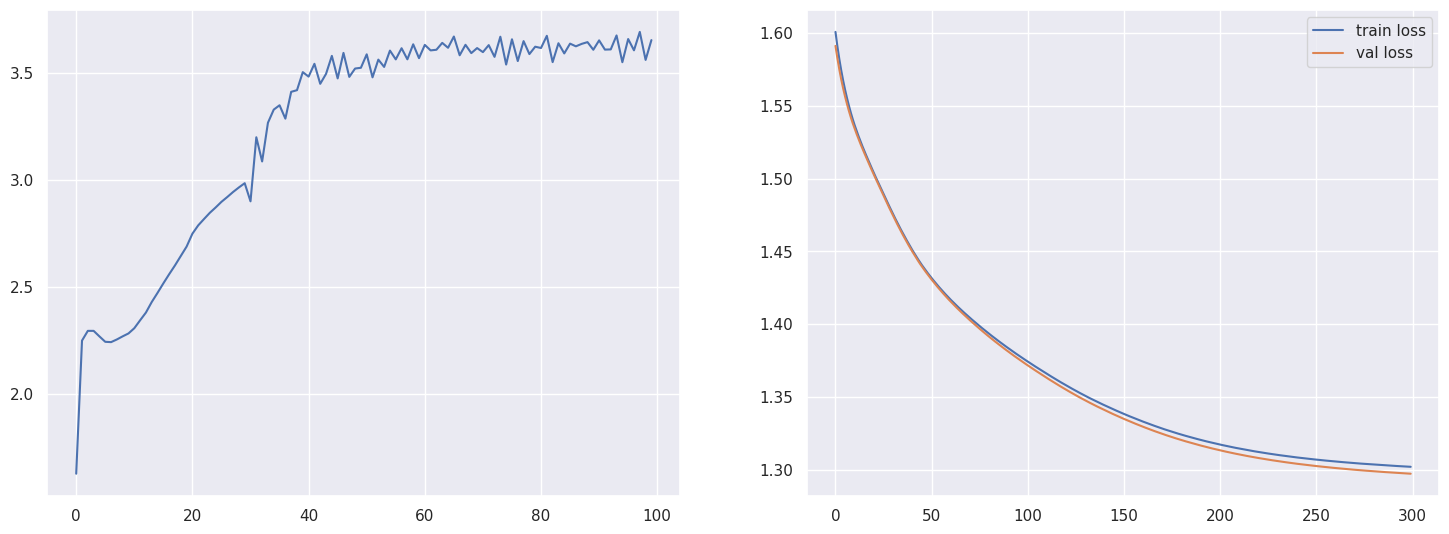

2


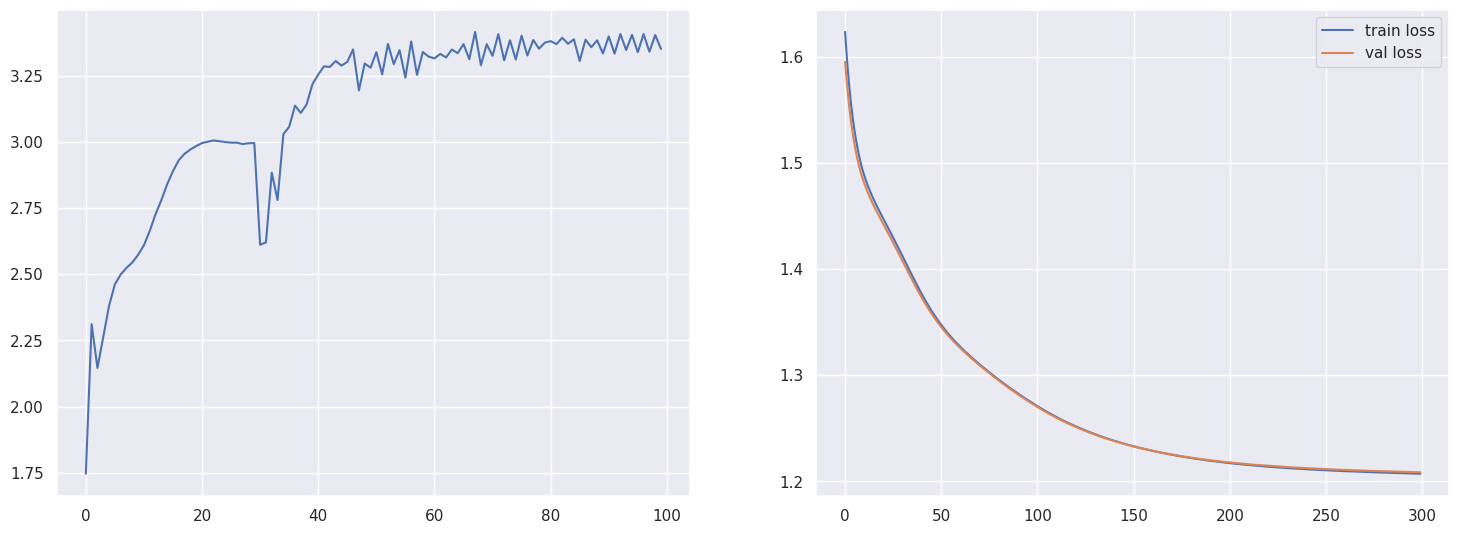

3


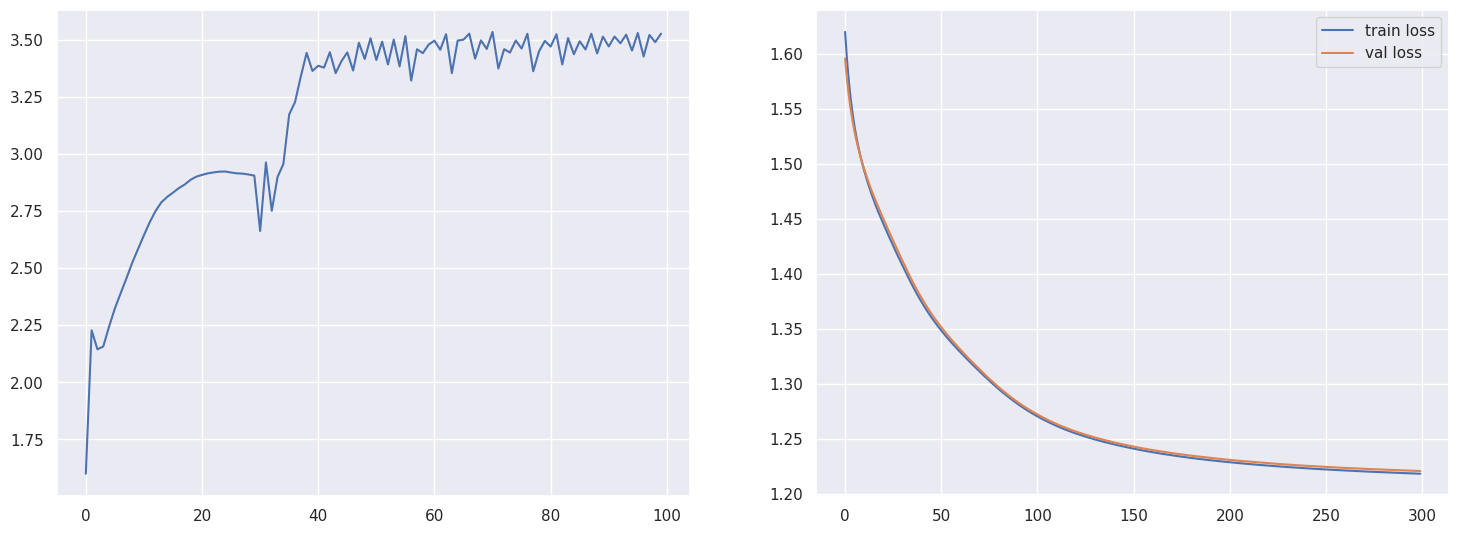

4


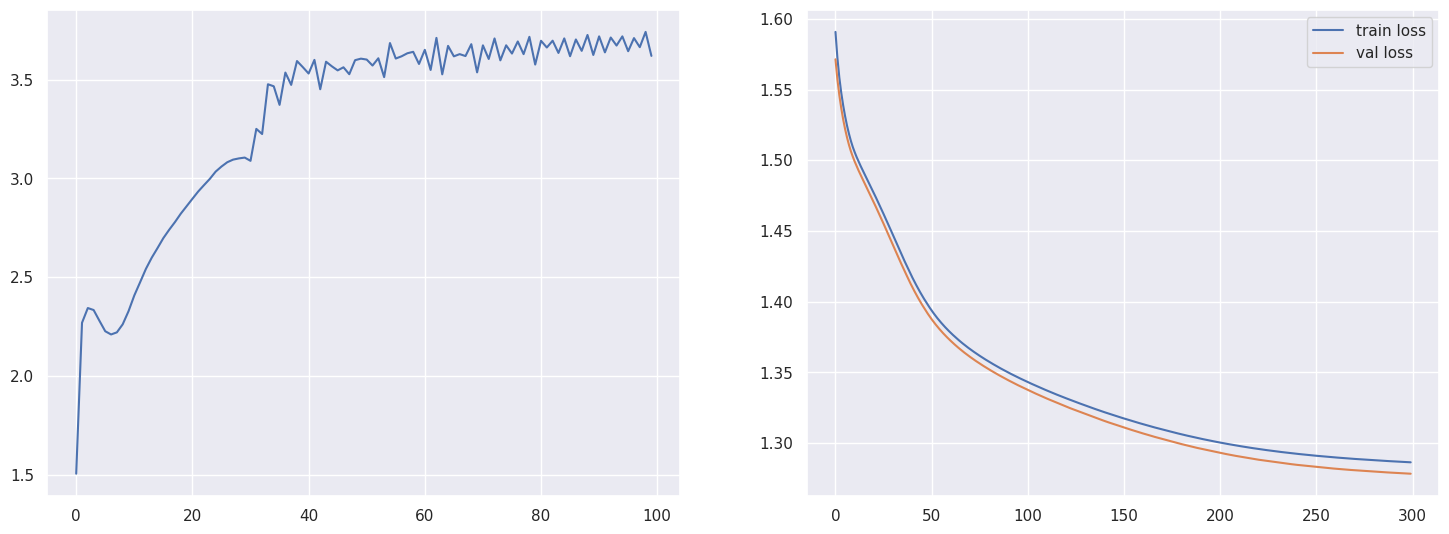

5


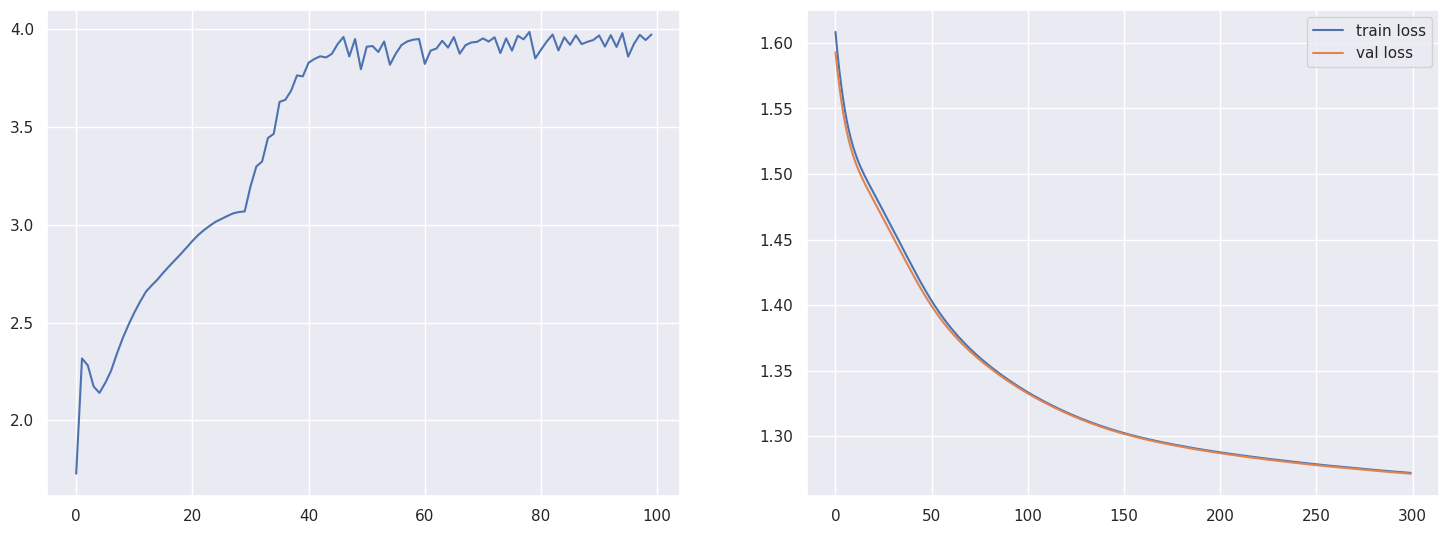

6


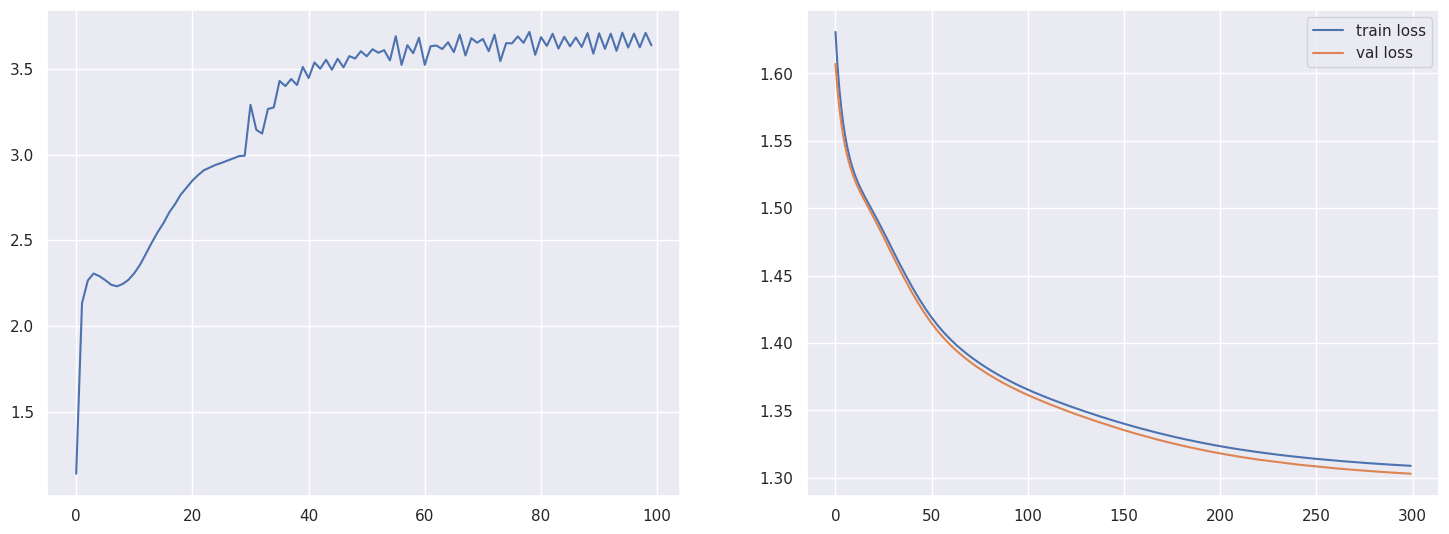

7


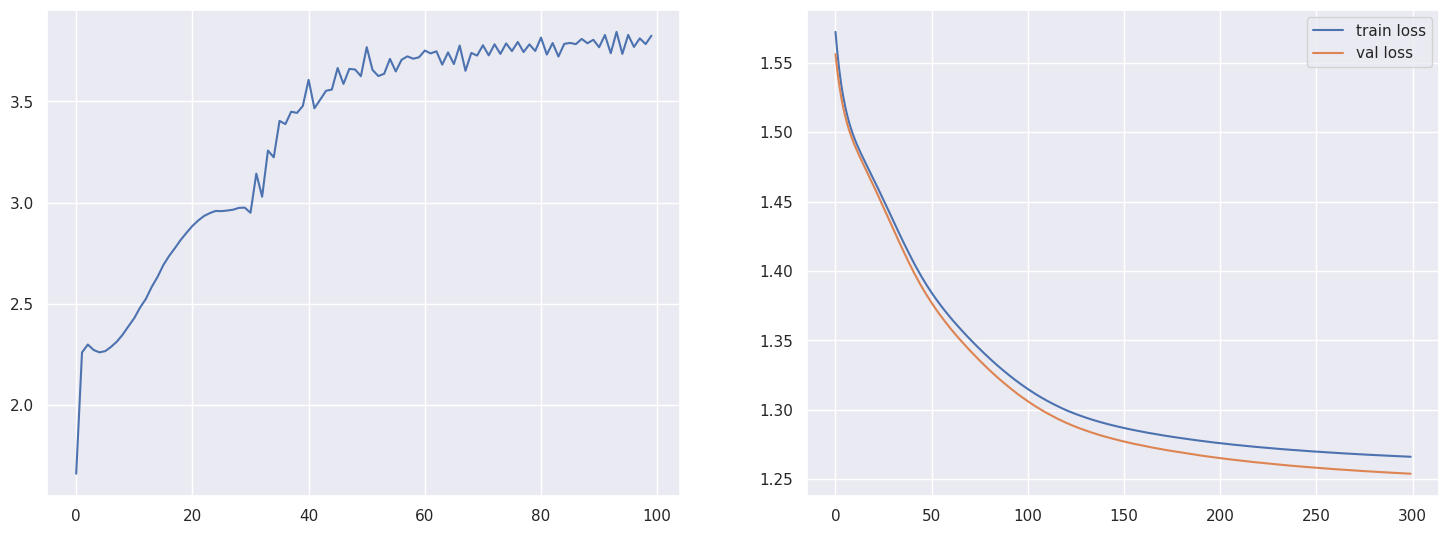

8


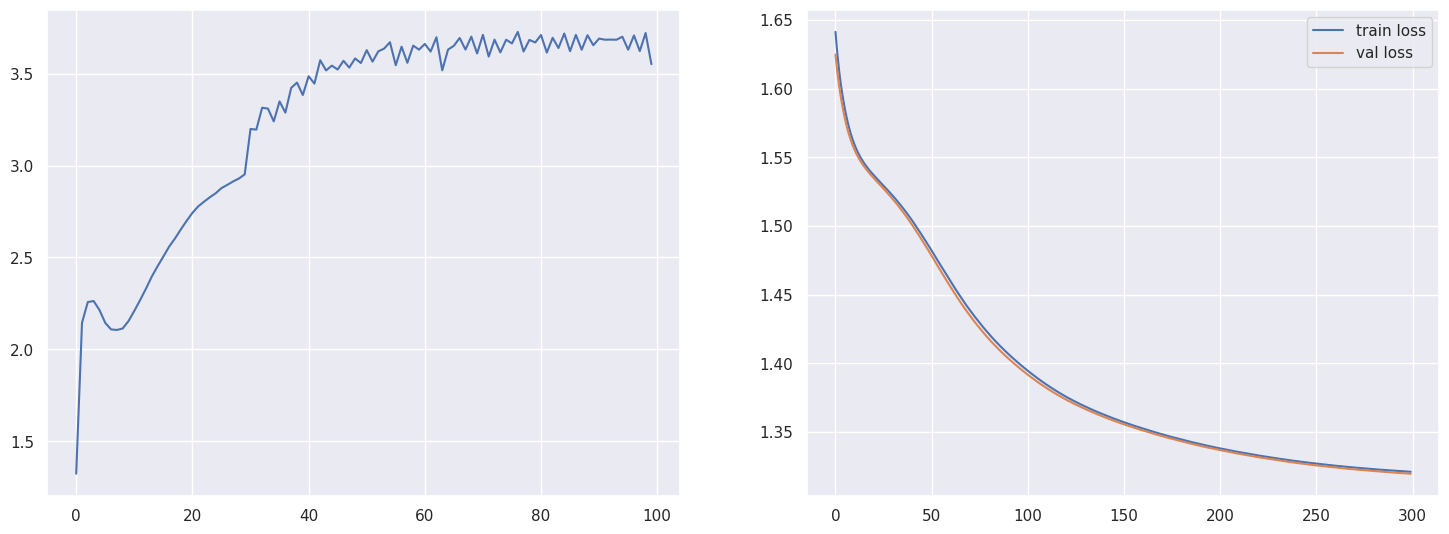

9


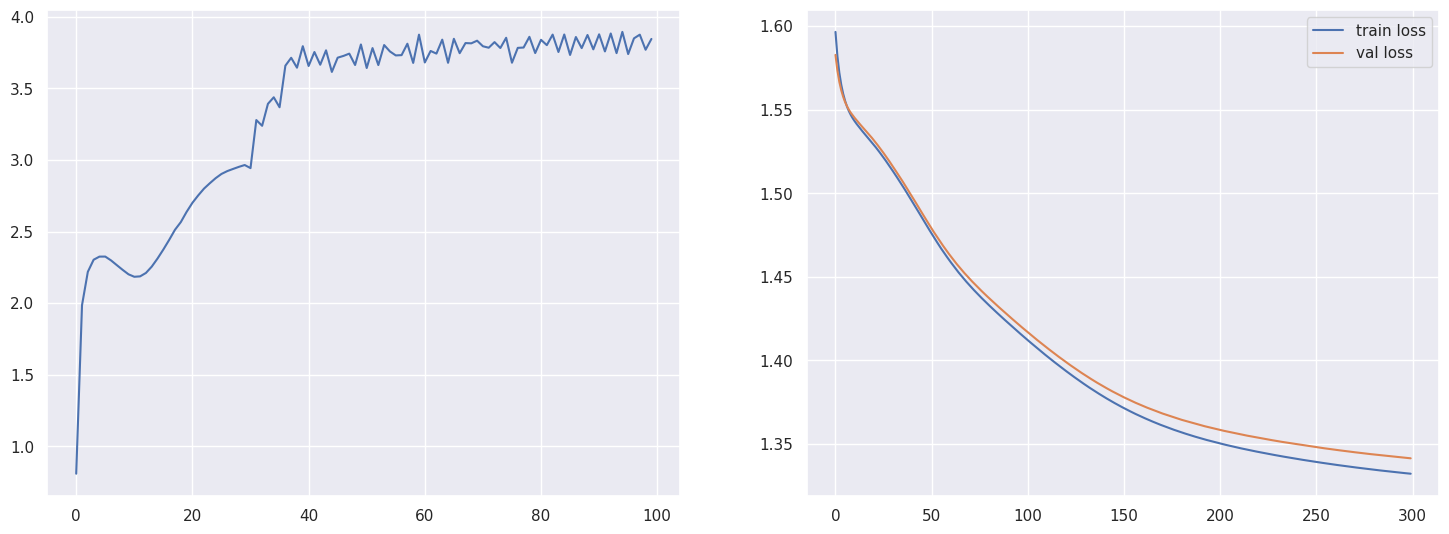

In [6]:

spg_cv = []
init_seed = 0
for rep_index in range(10):
    spg_curve = StrategicGD_soft(cost_coef=0.1, lr_pi=0.15, lr_prob=0.2, num_epoch = 300, seed=init_seed + rep_index, dim_v=dim_v, card_u=card_u, beta=beta, H=H, len_seq=len_seq, T=T, n=n, n_eval=n_eval)        
    spg_cv.extend(spg_curve)


In [ ]:
epoch = list(range(T)) * 10
df = pd.DataFrame({'epoch': epoch, "spg": spg_cv})
df.to_csv("result/synthetic_nov_softmax.csv")

In [ ]:
cutoff_cv = []
init_seed = 0
for rep_index in range(10):
    cutoff_cv.append(cutoff_soft(seed=init_seed + rep_index, card_u=card_u, beta=beta, n_eval=n_eval))        

In [9]:
cutoff_cv

[3.0234031677246094,
 3.0345590114593506,
 3.044523000717163,
 3.02654767036438,
 3.0160269737243652,
 3.0335540771484375,
 3.010422945022583,
 3.063485860824585,
 3.0267539024353027,
 3.0331265926361084]

In [10]:
sum(cutoff_cv)/len(cutoff_cv)

3.0312403202056886